In [1]:
from sklearn.datasets import load_boston
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy import random
import time

from sklearn import datasets, linear_model
from sklearn import metrics, cross_validation
from sklearn.utils import shuffle
from sklearn.model_selection import KFold

/Users/vijay.patel/miniconda2/envs/py36-learning/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
boston = load_boston()
print(boston.data.shape)

(506, 13)


In [3]:
type(boston)

sklearn.utils.Bunch

In [4]:
print(boston.DESCR)
print(boston.keys())
print(boston.feature_names)
print(boston.data.shape)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [5]:
X = boston.data

In [6]:
X[0:2, :]

array([[6.3200e-03, 1.8000e+01, 2.3100e+00, 0.0000e+00, 5.3800e-01,
        6.5750e+00, 6.5200e+01, 4.0900e+00, 1.0000e+00, 2.9600e+02,
        1.5300e+01, 3.9690e+02, 4.9800e+00],
       [2.7310e-02, 0.0000e+00, 7.0700e+00, 0.0000e+00, 4.6900e-01,
        6.4210e+00, 7.8900e+01, 4.9671e+00, 2.0000e+00, 2.4200e+02,
        1.7800e+01, 3.9690e+02, 9.1400e+00]])

In [7]:
y = boston.target

In [8]:
y[0:2]

array([24. , 21.6])

## Prepare train/test sets

In [9]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size = 0.33, random_state = 5)

print("X_train shape: " + str(X_train.shape))
print("y_train shape: " + str(y_train.shape))
print("X_test shape: " + str(X_test.shape))
print("y_test shape: " + str(y_test.shape))

X_train shape: (339, 13)
y_train shape: (339,)
X_test shape: (167, 13)
y_test shape: (167,)


## Define linear regression functions

In [10]:
def predict(X, theta):
    return X.dot(theta.T)

def sum_squared_error(y, y_pred):
    square_of_errors = np.square(y_pred - y)
    return np.sum(square_of_errors)

def mean_squared_error(y, y_pred):
    m = y.shape[0]
    return (1 / (m)) * sum_squared_error(y, y_pred)
    
def gradient(X, y, y_pred):
    m = X.shape[0]
    error = y_pred - y
    gradient = (1/m) * X.T.dot(error)
    return (gradient, error)
    
def gradient_descent(X, y, theta, alpha, iterations):
    m = X.shape[0]
    for i in range(iterations):
        # Move in opposite direction to gradient, hence minus gradient.
        # Alpha seems to temper the gradient change, preventing huge swings. It should be low.
        y_pred = predict(X, theta)
        grad, error = gradient(X, y, y_pred)
        theta = theta - (alpha * grad)
        log_gradient_descent_step(i, theta, error)
            
    return theta

# theta is updated after calculating gradient for just one example
# This is cheaper than calculating gradient across all examples, before adjusting theta \
# especially where we have a huge number of examples
def gradient_descent_stochastic(X, y, theta, alpha, iterations, batch_gen):
  
    for X, y in batch_gen(X, y):
        for i in range(iterations):
            for j, _ in enumerate(X):
                y_pred = predict(X, theta)
                grad, error = gradient(X[j], y[j], y_pred[j])
                theta = theta - (alpha * grad)

            log_gradient_descent_step(i, theta, error)
        
    return theta

# Shuffle entire data set and apply stochastic gradient descent on it all
def gradient_descent_stochastic_full_batch(X, y, theta, alpha, iterations):
    
    def batch_gen(X, y):
        X, y = shuffle(X, y, random_state=0)
        yield (X, y)
    
    return gradient_descent_stochastic(X, y, theta, alpha, iterations, batch_gen)
    
# 
def gradient_descent_stochastic_mini_batch(X, y, theta, alpha, iterations, batch_size):
    
    def batch_gen(X, y):
        random_idxs = random.choice(len(y), len(y), replace=False)
        X_shuffled = X[random_idxs,:]
        y_shuffled = y[random_idxs]
        for i in range(0, len(y), batch_size):
            yield (X_shuffled[i:i+batch_size,:], y_shuffled[i:i+batch_size])
    
    return gradient_descent_stochastic(X, y, theta, alpha, iterations, batch_gen)


## Define helper function

In [11]:
def plot_actual_over_predicted(y_actual, y_pred):
    plt.scatter(y_actual, y_pred)
    plt.plot([0, 50], [0, 50], '--k')
    plt.xlabel("Prices: $Y_i$")
    plt.ylabel("Predicted prices: $\hat{Y}_i$")
    plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$")
    plt.show()

def plot_residuals(X_train, y_train, X_test, y_test, theta):
    y_pred_for_X_train = predict(X_train, theta)
    y_pred_for_X_test = predict(X_test, theta)
    plt.scatter(y_pred_for_X_train, y_pred_for_X_train - y_train, c='b', s=40, alpha=0.5)
    plt.scatter(y_pred_for_X_test, y_pred_for_X_test - y_test, c='g', s=40)
    plt.hlines(y=0, xmin=0, xmax=50)
    plt.title('Residual plot using training (blue) and test (green) data')
    plt.ylabel('Residuals')
    plt.show()
    
def log_gradient_descent_step(it, theta, error):
     if (debug):
        print("Iteration: " + str(it))    
        print("  Theta: " + str(theta))
        print("  Error: " + str(error))
        
def calculate_cost_of_theta(X_train, y_train, X_test, y_test, theta):
    y_pred_for_X_train = predict(X_train, theta)
    y_pred_for_X_test = predict(X_test, theta)
    mse_on_train = mean_squared_error(y_train, y_pred_for_X_train)
    mse_on_test = mean_squared_error(y_test, y_pred_for_X_test)
    print('Theta: \n', theta)
    print("Mean squared error (train):", mse_on_train)
    print("Mean squared error (test):", mse_on_test)
        
def run_timed(func):
    start = time.clock()
    results = func()
    print("Time taken:", time.clock() - start)
    return results


## Test linear regression on limited data set

In [12]:
debug = True    

t_X = np.array([[1, 2, 3],[4, 5, 6]])
t_y = np.array([6, 15])
t_theta = np.array([2, 1, 1])
print("Theta: " + str(t_theta))

# Test cost function
t_y_pred = predict(t_X, t_theta)
cost = mean_squared_error(t_y, t_y_pred)
print("Cost: " + str(cost))
    
# Test gradient function
g, e = gradient(t_X, t_y, t_y_pred)
print("Gradient: " + str(g))

# Test gradient descent
print("Testing gradient descent")
t_initial_theta = np.array([4,3,2])
optimised_theta = gradient_descent(t_X, t_y, t_initial_theta, 0.01, 100)
t_y_pred = predict(t_X, optimised_theta)
mse = mean_squared_error(t_y, t_y_pred)
print("Optimised theta: " + str(optimised_theta))
print("Optimised theta cost: " + str(mse))

# Test gradient descent stochastic (full batch)
print("Testing gradient descent stochastic (full batch)")
optimised_theta = gradient_descent_stochastic_full_batch(t_X, t_y, t_initial_theta, 0.01, 100)
t_y_pred = predict(t_X, optimised_theta)
mse = mean_squared_error(t_y, t_y_pred)
print("Optimised theta: " + str(optimised_theta))
print("Optimised theta cost: " + str(mse))

# Test gradient descent stochastic (mini batch)
print("Testing gradient descent stochastic (mini batch)")
optimised_theta = gradient_descent_stochastic_mini_batch(t_X, t_y, t_initial_theta, 0.01, 100, 2)
t_y_pred = predict(t_X, optimised_theta)
mse = mean_squared_error(t_y, t_y_pred)
print("Optimised theta: " + str(optimised_theta))
print("Optimised theta cost: " + str(mse))

Theta: [2 1 1]
Cost: 8.5
Gradient: [ 8.5 11.  13.5]
Testing gradient descent
Iteration: 0
  Theta: [3.39 2.2  1.01]
  Error: [10 28]
Iteration: 1
  Theta: [3.0535 1.7613 0.4691]
  Error: [ 4.82 15.62]
Iteration: 2
  Theta: [2.866881  1.5205885 0.174296 ]
  Error: [1.9834 8.8351]
Iteration: 3
  Theta: [2.76240142 1.38837298 0.01434453]
  Error: [0.430946  5.1162425]
Iteration: 4
  Theta: [ 2.70293976  1.31561272 -0.07171431]
  Error: [-0.41781902  3.07753778]
Iteration: 5
  Theta: [ 2.66815391  1.27543408 -0.11728575]
  Error: [-0.88097773  1.95953678]
Iteration: 6
  Theta: [ 2.64689666  1.25311064 -0.14067537]
  Error: [-1.13283518  1.34607155]
Iteration: 7
  Theta: [ 2.63305945  1.24057253 -0.15191438]
  Error: [-1.26890816  1.00908763]
Iteration: 8
  Theta: [ 2.62329485  1.23339757 -0.15649972]
  Error: [-1.34153861  0.8236142 ]
Iteration: 9
  Theta: [ 2.61576852  1.22916243 -0.15744365]
  Error: [-1.37940918  0.72116891]
Iteration: 10
  Theta: [ 2.60947522  1.2265392  -0.15639682]
 

## Run Linear Regression From Scikit-learn

<b>Provides some results to compare against</b>

Coefficients: 
 [-1.56381297e-01  3.85490972e-02 -2.50629921e-02  7.86439684e-01
 -1.29469121e+01  4.00268857e+00 -1.16023395e-02 -1.36828811e+00
  3.41756915e-01 -1.35148823e-02 -9.88866034e-01  1.20588215e-02
 -4.72644280e-01]
Mean squared error (train): 19.55
Mean squared error (test): 28.54


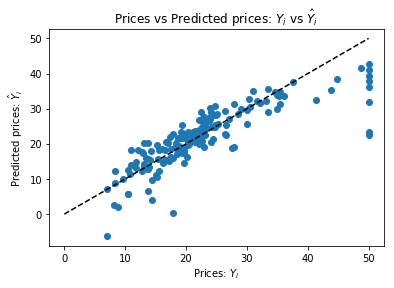

In [13]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

print('Coefficients: \n', regr.coef_)
print("Mean squared error (train): %.2f" % metrics.mean_squared_error(y_train, regr.predict(X_train)))
print("Mean squared error (test): %.2f" % metrics.mean_squared_error(y_test, y_pred))

plot_actual_over_predicted(y_test, y_pred)

## Run Linear Regression With Gradient Descent

Theta: 
 [0.47759411 0.89104096 0.56891574 0.92583567 0.04752898 0.42791525
 0.06802221 0.98431533 0.71780412 0.6002002  0.66280002 0.74599727
 0.99036369]
Mean squared error (train): 312501.24296656135
Mean squared error (test): 313676.0038378752


Time taken: 14.214736
Theta: 
 [-0.14686528  0.06502028 -0.02566795  0.97294164  0.17935772  3.46778246
  0.03924567 -0.32874079  0.19030233 -0.00816798 -0.01348247  0.02226198
 -0.57568902]
Mean squared error (train): 25.953135711751145
Mean squared error (test): 34.76423927850408


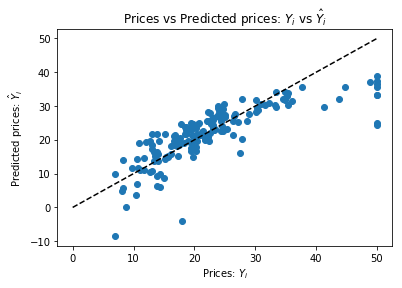

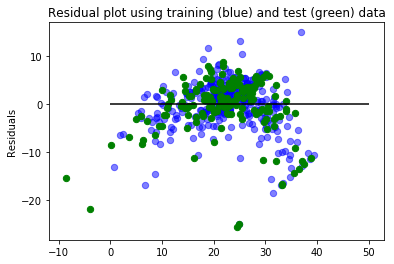

In [14]:
debug = False
num_of_iterations = 300000
alpha = 0.000004 # learning rate

initial_theta = np.random.rand((X.shape[1]))
calculate_cost_of_theta(X_train, y_train, X_test, y_test, initial_theta)

print('\n')

optimised_theta = run_timed(lambda: gradient_descent(X_train, y_train, initial_theta, alpha, num_of_iterations))
calculate_cost_of_theta(X_train, y_train, X_test, y_test, optimised_theta)

y_pred = X_test.dot(optimised_theta.T)
plot_actual_over_predicted(y_test, y_pred)
plot_residuals(X_train, y_train, X_test, y_test, optimised_theta)

## Run Linear Regression With Stochastic Gradient Descent - Full Batch

Theta: 
 [0.66520005 0.56733392 0.92870321 0.72455383 0.01382679 0.33221514
 0.12245953 0.20441193 0.70431914 0.18866736 0.35841561 0.27851825
 0.04561537]
Mean squared error (train): 41135.80441144175
Mean squared error (test): 41352.1716877821


Time taken: 6.4566669999999995
Theta: 
 [-1.00321733e-01  9.28616974e-02  1.51672635e-02  7.53337937e-01
  9.99730767e-02  2.56313410e+00  6.01431374e-02 -3.66177771e-01
  1.62180351e-01 -9.23367115e-04  2.28428632e-01  2.70855742e-02
 -7.05810944e-01]
Mean squared error (train): 45.077189117744666
Mean squared error (test): 48.64301172218536


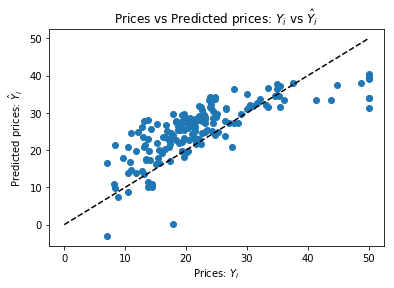

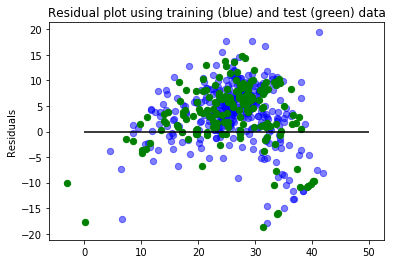

In [15]:
debug = False
num_of_iterations = 3000
alpha = 0.00001 # learning rate

initial_theta = np.random.rand((X.shape[1]))
calculate_cost_of_theta(X_train, y_train, X_test, y_test, initial_theta)

print('\n')

optimised_theta = run_timed(lambda: gradient_descent_stochastic_full_batch(X_train, y_train, initial_theta, alpha, num_of_iterations))
calculate_cost_of_theta(X_train, y_train, X_test, y_test, optimised_theta)

y_pred = X_test.dot(optimised_theta.T)
plot_actual_over_predicted(y_test, y_pred)
plot_residuals(X_train, y_train, X_test, y_test, optimised_theta)

## Run Linear Regression With Stochastic Gradient Descent - Mini Batch

Theta: 
 [0.78556822 0.90900601 0.61008502 0.58598145 0.16364093 0.13342273
 0.21786205 0.222783   0.35070284 0.89333436 0.48207861 0.96734123
 0.45412724]
Mean squared error (train): 570687.3219533328
Mean squared error (test): 574612.9352375777


Time taken: 5.410384999999998
Theta: 
 [-0.46317087  0.09814698  0.12110626  0.61215511  0.34823286  4.35165397
  0.00720377 -0.4596869   0.18946802 -0.0118372   0.07462342 -0.00448568
 -0.30036419]
Mean squared error (train): 38.26938890701563
Mean squared error (test): 50.92450452942272


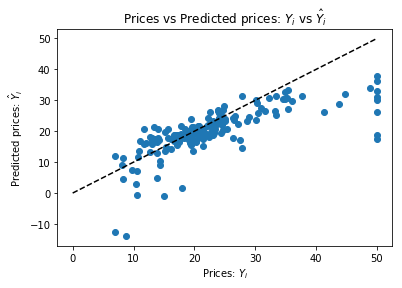

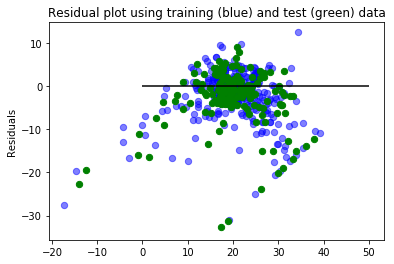

In [21]:
debug = False
num_of_iterations = 3000
alpha = 0.00002 # learning rate
batch_size = 80

initial_theta = np.random.rand((X.shape[1]))
calculate_cost_of_theta(X_train, y_train, X_test, y_test, initial_theta)

print('\n')

optimised_theta = run_timed(lambda: gradient_descent_stochastic_mini_batch(X_train, y_train, initial_theta, alpha, num_of_iterations, batch_size))
calculate_cost_of_theta(X_train, y_train, X_test, y_test, optimised_theta)

y_pred = X_test.dot(optimised_theta.T)
plot_actual_over_predicted(y_test, y_pred)
plot_residuals(X_train, y_train, X_test, y_test, optimised_theta)

Next steps:

- Will feature scaling help?
- Can I incorporate a stopping condition?
- Can I reduce dimensions?
- Adding cost curves for a test data set - use scikit learn to generate data
- Is there any outlier data I can remove?